In [1]:
using DataFrames
ENV["COLUMNS"] = 12345678
using DelimitedFiles, CSV
using StatsBase
using JuMP, Ipopt
using CairoMakie
CairoMakie.activate!(type="svg")

Should be able to use LSMR algorithm instead for ridge formulation:

https://iterativesolvers.julialinearalgebra.org/stable/linear_systems/lsmr/#IterativeSolvers.lsmr

In [3]:
ipeds = CSV.File("ipeds.csv", drop=(i, name)->i==185) |> DataFrame
dropmissing!(ipeds)

# Only work with schools whose enrollment is over 9000
ipeds = ipeds[ipeds[:, "UGENTERN (EF2019D)"] .> 4000, :]

┌ Warning: thread = 1 warning: only found 184 / 185 columns around data row: 2807. Filling remaining columns with `missing`
└ @ CSV /home/max/.julia/packages/CSV/Zl2ww/src/file.jl:612


,UnitID,Institution Name,CINSON (DRVIC2019),COTSON (DRVIC2019),DVADM01 (DRVADM2019),DVADM04 (DRVADM2019),GBA4RTT (DRVGR2019),GBA6RTT (DRVGR2019),ACTCM25 (ADM2019),ACTCM75 (ADM2019),SATMT25 (ADM2019),SATMT75 (ADM2019),SATVR75 (ADM2019),SATVR25 (ADM2019),UGENTERN (EF2019D),CINSON (DRVIC2018),COTSON (DRVIC2018),DVADM01 (DRVADM2018_RV),DVADM04 (DRVADM2018_RV),GBA4RTT (DRVGR2018_RV),GBA6RTT (DRVGR2018_RV),ACTCM25 (ADM2018_RV),ACTCM75 (ADM2018_RV),SATMT25 (ADM2018_RV),SATMT75 (ADM2018_RV),SATVR75 (ADM2018_RV),SATVR25 (ADM2018_RV),UGENTERN (EF2018D_RV),CINSON (DRVIC2017),COTSON (DRVIC2017),DVADM01 (DRVADM2017_RV),DVADM04 (DRVADM2017_RV),GBA4RTT (DRVGR2017_RV),GBA6RTT (DRVGR2017_RV),ACTCM25 (ADM2017_RV),ACTCM75 (ADM2017_RV),SATMT25 (ADM2017_RV),SATMT75 (ADM2017_RV),SATVR75 (ADM2017_RV),SATVR25 (ADM2017_RV),UGENTERN (EF2017D_RV),CINSON (DRVIC2016),COTSON (DRVIC2016),DVADM01 (DRVADM2016_RV),DVADM04 (DRVADM2016_RV),GBA4RTT (DRVGR2016_RV),GBA6RTT (DRVGR2016_RV),ACTCM25 (ADM2016_RV),ACTCM75 (ADM2016_RV),SATMT25 (ADM2016_RV),SATMT75 (ADM2016_RV),SATVR75 (ADM2016_RV),SATVR25 (ADM2016_RV),UGENTERN (EF2016D_RV),CINSON (DRVIC2015),COTSON (DRVIC2015),DVADM01 (DRVADM2015_RV),DVADM04 (DRVADM2015_RV),GBA4RTT (DRVGR2015_RV),GBA6RTT (DRVGR2015_RV),ACTCM25 (ADM2015_RV),ACTCM75 (ADM2015_RV),SATMT25 (ADM2015_RV),SATMT75 (ADM2015_RV),SATVR75 (ADM2015_RV),SATVR25 (ADM2015_RV),UGENTERN (EF2015D_RV),CINSON (DRVIC2014),COTSON (DRVIC2014),DVADM01 (DRVADM2014_RV),DVADM04 (DRVADM2014_RV),GBA4RTT (DRVGR2014_RV),GBA6RTT (DRVGR2014_RV),ACTCM25 (ADM2014_RV),ACTCM75 (ADM2014_RV),SATMT25 (ADM2014_RV),SATMT75 (ADM2014_RV),SATVR75 (ADM2014_RV),SATVR25 (ADM2014_RV),UGENTERN (EF2014D_RV),CINSON (DRVIC2013_RV),COTSON (DRVIC2013_RV),DVIC01 (DRVIC2013_RV),DVIC04 (DRVIC2013_RV),GBA4RTT (DRVGR2013_RV),GBA6RTT (DRVGR2013_RV),ACTCM25 (IC2013_RV),ACTCM75 (IC2013_RV),SATMT25 (IC2013_RV),SATMT75 (IC2013_RV),SATVR75 (IC2013_RV),SATVR25 (IC2013_RV),UGENTERN (EF2013D_RV),CINSON (DRVIC2012_RV),COTSON (DRVIC2012_RV),DVIC01 (DRVIC2012_RV),DVIC04 (DRVIC2012_RV),GBA4RTT (DRVGR2012_RV),GBA6RTT (DRVGR2012_RV),ACTCM25 (IC2012_RV),ACTCM75 (IC2012_RV),SATMT25 (IC2012_RV),SATMT75 (IC2012_RV),SATVR75 (IC2012_RV),SATVR25 (IC2012_RV),UGENTERN (EF2012D_RV),CINSON (DRVIC2011_RV),COTSON (DRVIC2011_RV),DVIC01 (DRVIC2011_RV),DVIC04 (DRVIC2011_RV),GBA4RTT (DRVGR2011_RV),GBA6RTT (DRVGR2011_RV),ACTCM25 (IC2011_RV),ACTCM75 (IC2011_RV),SATMT25 (IC2011_RV),SATMT75 (IC2011_RV),SATVR75 (IC2011_RV),SATVR25 (IC2011_RV),UGENTERN (EF2011D_RV),CINSON (DRVIC2010_RV),COTSON (DRVIC2010_RV),DVIC01 (DRVIC2010_RV),DVIC04 (DRVIC2010_RV),GBA4RTT (DRVGR2010_RV),GBA6RTT (DRVGR2010_RV),ACTCM25 (IC2010_RV),ACTCM75 (IC2010_RV),SATMT25 (IC2010_RV),SATMT75 (IC2010_RV),SATVR75 (IC2010_RV),SATVR25 (IC2010_RV),UGENTERN (EF2010D_RV),CINSON (DRVIC2009_RV),COTSON (DRVIC2009_RV),DVIC01 (DRVIC2009_RV),DVIC04 (DRVIC2009_RV),GBA4RTT (DRVGR2009_RV),GBA6RTT (DRVGR2009_RV),ACTCM25 (IC2009_RV),ACTCM75 (IC2009_RV),SATMT25 (IC2009_RV),SATMT75 (IC2009_RV),SATVR75 (IC2009_RV),SATVR25 (IC2009_RV),UGENTERN (EF2009D_RV),CINSON (DRVIC2008_RV),COTSON (DRVIC2008_RV),DVIC01 (DRVIC2008_RV),DVIC04 (DRVIC2008_RV),GBA4RTT (DRVGR2008_RV),GBA6RTT (DRVGR2008_RV),ACTCM25 (IC2008_RV),ACTCM75 (IC2008_RV),SATMT25 (IC2008_RV),SATMT75 (IC2008_RV),SATVR75 (IC2008_RV),SATVR25 (IC2008_RV),UGENTERN (EF2008D_RV),CINSON (DRVIC2007),COTSON (DRVIC2007),DVIC01 (DRVIC2007),DVIC04 (DRVIC2007),GBA4RTT (DRVGR2007_RV),GBA6RTT (DRVGR2007_RV),ACTCM25 (IC2007),ACTCM75 (IC2007),SATMT25 (IC2007),SATMT75 (IC2007),SATVR75 (IC2007),SATVR25 (IC2007),UGENTERN (EF2007D_RV),CINSON (DRVIC2006),COTSON (DRVIC2006),DVIC01 (DRVIC2006),DVIC04 (DRVIC2006),GBA4RTT (DRVGR2006_RV),GBA6RTT (DRVGR2006_RV),ACTCM25 (IC2006),ACTCM75 (IC2006),SATMT25 (IC2006),SATMT75 (IC2006),SATVR75 (IC2006),SATVR25 (IC2006),UGENTERN (EF2006D_RV)
,Int64,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int6

In [4]:
datanames =[    "CINSON "  "CINSON "
                "COTSON "  "COTSON "
                "DVADM01"  "DVIC01 "
                "DVADM04"  "DVIC04 "
                "GBA4RTT"  "GBA4RTT"
                "GBA6RTT"  "GBA6RTT"
                "ACTCM25"  "ACTCM25"
                "ACTCM75"  "ACTCM75"
                "SATMT25"  "SATMT25"
                "SATMT75"  "SATMT75"
                "SATVR75"  "SATVR75"
                "SATVR25"  "SATVR25"]

years = 2006:2019

T = length(years)
N = size(ipeds)[1]
M = size(datanames)[1]

# demand[t, n] = demand for school n at year 2005+t
demand = zeros(Float64, T, N)

for t in 1:T
    dex = findfirst(x->occursin("UGENTERN", x) && occursin(string(years[t]), x), names(ipeds))
    demand[t, :] = ipeds[:, dex]
end

# exog[t, n, m] = value of exogeneous variable m at school n in year 2005+t
exog = zeros(Float64, T, N, M)
exog_names = ones(String, T, M)

for t in 1:T, m in 1:M
    dex = findfirst(x-> (occursin(datanames[m, 1], x) || occursin(datanames[m, 2], x))
                        && occursin(string(years[t]), x),
                    names(ipeds))
    exog_names[t, m] = names(ipeds)[dex]
    if dex === nothing
        @show t, m
    end
    exog[t, :, m] = ipeds[:, dex]
end

weights = copy(demand);

In [5]:
demand_ms = mean_and_std(demand)
demand .-= demand_ms[1]
demand ./= demand_ms[2]

exog_ms = mean_and_std(exog)
exog .-= exog_ms[1]
exog ./= exog_ms[2];

In [16]:
function estimate_lasso(demand=demand, exog=exog, weights=weights)
    T, N, M = size(exog)
        
    model = Model(Ipopt.Optimizer)
    
    set_silent(model)
    
    @variable(model, X[1:N, 1:N])
    @variable(model, AbsX[1:N, 1:N])
    
    # Last entry is a bias term
    @variable(model, Y[1:N, 1:M+1])
    @variable(model, AbsY[1:N, 1:M+1])
    
    for n in 1:N
        for j in 1:N
            @constraint(model, AbsX[n, j] ≥ X[n, j] * N^2)
            @constraint(model, AbsX[n, j] ≥ -X[n, j] * N^2)
        end
        for m in 1:M+1
            @constraint(model, AbsY[n, m] ≥ Y[n, m] * N * M)
            @constraint(model, AbsY[n, m] ≥ -Y[n, m] * N * M)
        end
    end
    
    @expression(model, PredDemand[t in 2:T, n in 1:N],
                sum(X[n, j] * demand[t-1, j] for j in 1:N) +
                sum(Y[n, m] * exog[t-1, n, m] for m in 1:M) + 
                Y[n, M+1])
    
    
    # Save year T for validation
    @expression(model, TrainError,
                sum( weights[t, n] *   # Weight errors by size of demand
                     (PredDemand[t, n] - demand[t, n])^2 for t in 2:T-1, n in 1:N))
    # Test error
    @expression(model, TestError,
                sum( weights[T, n] *
                     (PredDemand[T, n] - demand[T, n])^2 for n in 1:N))
    
    @expression(model, Lasso,
                    sum(AbsX[n, j] for n in 1:N, j in 1:N) +
                    sum(AbsY[n, m] for n in 1:N, m in 1:M+1))
    
    
    gammas = vcat(10.0 .^ range(-4, 6, length=10))
    trainerrors = Float64[]
    testerrors = Float64[]
    preds = Matrix{Float64}[]
    Xs = Matrix{Float64}[]
    Ys = Matrix{Float64}[]
    
    for g in gammas
        @objective(model, Min, g * TrainError + Lasso)
        
        optimize!(model)
        @show g
        
#         println("  Slackness in lasso constraint: ",
#                 round(value(gamma) - (sum(value(AbsX[n, j]) for n in 1:N, j in 1:N) +
#                                       sum(value(AbsY[n, m]) for n in 1:N, m in 1:M+1)),
#                       sigdigits=4))
        println("  Termination status: ", termination_status(model))
        println()

        push!(trainerrors, value.(TrainError))
        push!(testerrors, value.(TestError))
        push!(preds, value.(PredDemand).data)
        push!(Xs, value.(X))
        push!(Ys, value.(Y))
    end

    return (; gammas, trainerrors, testerrors, preds, Xs, Ys)
end


function estimate_ridge(demand=demand, exog=exog, weights=weights)
    T, N, M = size(exog)
        
    model = Model(Ipopt.Optimizer)
    
    set_silent(model)
    
    @variable(model, X[1:N, 1:N])
    
    # Last entry is a bias term
    @variable(model, Y[1:N, 1:M+1])
    
    @expression(model, PredDemand[t in 2:T, n in 1:N],
                sum(X[n, j] * demand[t-1, j] for j in 1:N) +
                sum(Y[n, m] * exog[t-1, n, m] for m in 1:M) + 
                Y[n, M+1])
    
    
    # Save year T for validation
    @expression(model, TrainError,
                sum( weights[t, n] *   # Weight errors by size of demand
                     (PredDemand[t, n] - demand[t, n])^2 for t in 2:T-1, n in 1:N))
    # Test error
    @expression(model, TestError,
                sum( weights[T, n] *
                     (PredDemand[T, n] - demand[T, n])^2 for n in 1:N))
    
    @expression(model, Ridge,
                    sum(X[n, j]^2 for n in 1:N, j in 1:N) +
                    sum(Y[n, m]^2 for n in 1:N, m in 1:M+1))
    
    gammas = 10.0 .^ (-8:0.25:-3)
    trainerrors = Float64[]
    testerrors = Float64[]
    preds = Matrix{Float64}[]
    Xs = Matrix{Float64}[]
    Ys = Matrix{Float64}[]
    
    for g in gammas
        @objective(model, Min, g * TrainError + Ridge)
        optimize!(model)
        
        @show g
        println("  Termination status: ", termination_status(model))
        println()

        push!(trainerrors, value.(TrainError))
        push!(testerrors, value.(TestError))
        push!(preds, value.(PredDemand).data)
        push!(Xs, value.(X))
        push!(Ys, value.(Y))
    end

    return (; gammas, trainerrors, testerrors, preds, Xs, Ys)
end


res = estimate_ridge()
keys(res)

g = 1.0e-8
  Termination status: LOCALLY_SOLVED

g = 1.7782794100389228e-8
  Termination status: LOCALLY_SOLVED

g = 3.162277660168379e-8
  Termination status: LOCALLY_SOLVED

g = 5.623413251903491e-8
  Termination status: LOCALLY_SOLVED

g = 1.0e-7
  Termination status: LOCALLY_SOLVED

g = 1.7782794100389227e-7
  Termination status: LOCALLY_SOLVED

g = 3.162277660168379e-7
  Termination status: LOCALLY_SOLVED

g = 5.62341325190349e-7
  Termination status: LOCALLY_SOLVED

g = 1.0e-6
  Termination status: LOCALLY_SOLVED

g = 1.778279410038923e-6
  Termination status: LOCALLY_SOLVED

g = 3.162277660168379e-6
  Termination status: LOCALLY_SOLVED

g = 5.62341325190349e-6
  Termination status: LOCALLY_SOLVED

g = 9.999999999999999e-6
  Termination status: LOCALLY_SOLVED

g = 1.778279410038923e-5
  Termination status: LOCALLY_SOLVED

g = 3.1622776601683795e-5
  Termination status: LOCALLY_SOLVED

g = 5.623413251903491e-5
  Termination status: LOCALLY_SOLVED

g = 0.0001
  Termination status: 

(:gammas, :trainerrors, :testerrors, :preds, :Xs, :Ys)

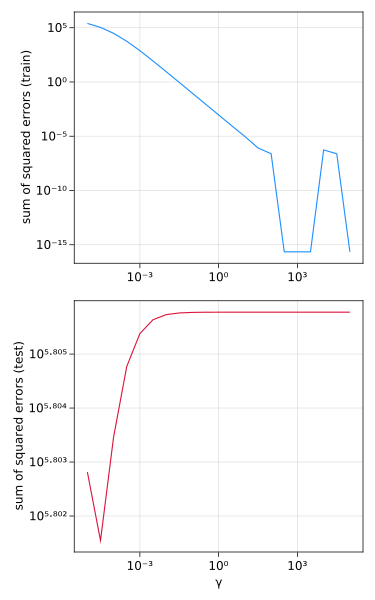

In [15]:
fig = Figure(resolution=(500, 800))#, legend=nothing, xlabel="γ", ylabel="sum of squared errors")


lines!(Axis(fig[1, 1], ylabel="sum of squared errors (train)", xscale=log10, yscale=log10),
       res.gammas, max.(eps(), res.trainerrors), color=:dodgerblue)#, 
lines!(Axis(fig[2, 1], ylabel="sum of squared errors (test)", xlabel="γ", xscale=log10, yscale=log10),
       res.gammas, max.(eps(), res.testerrors), color=:crimson)#, label="test", scale=:log10, c=:crimson)

fig

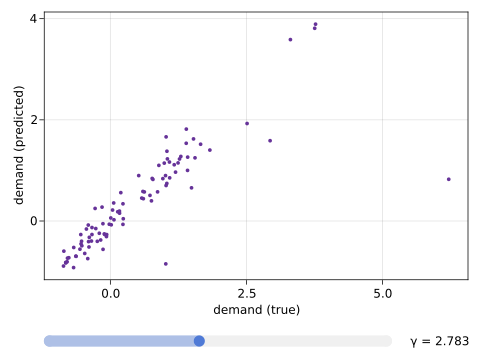

In [41]:
cs = repeat([:dodgerblue, :crimson, :olivedrab, :gold, :rebeccapurple], 5)
# marks = [:utriangle, :circle, :square, :x]

fig = Figure(resolution=(640, 480))
sl = Slider(fig[2, 1], range=1:length(res.gammas), startvalue=5)

yseries = lift(sl.value) do i
    res.preds[i][end, :]
end

labeltext = lift(sl.value) do i
    "γ = $(round(res.gammas[i], sigdigits=4))"
end

c = lift(sl.value) do i
    cs[i]
end

Label(fig[2, 2], labeltext)
scatter!(Axis(fig[1, 1:2], xlabel="demand (true)", ylabel="demand (predicted)"),
         demand[T, :],
         yseries,
         color=c,
         markersize=5)#msw=0, ma=0.5, ms=3,
#          label="γ = $(round(res.gammas[i], sigdigits=2))")

fig

┌ Info: Saved animation to 
│   fn = /home/max/AdmissionsLTI/gammascatter.gif
└ @ Plots /home/max/.julia/packages/Plots/Awg62/src/animation.jl:104


Plots.AnimatedGif("/home/max/AdmissionsLTI/gammascatter.gif")
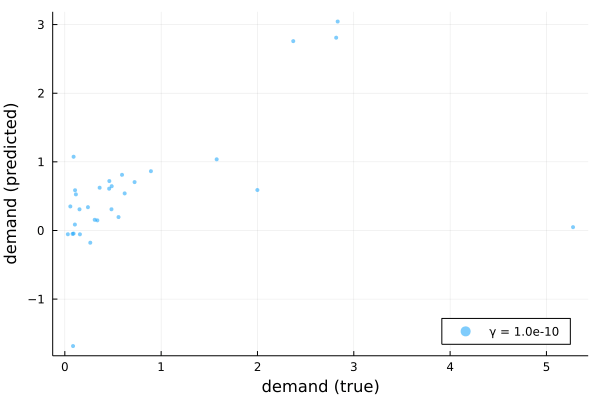

In [87]:
cs = theme_palette(:auto)
marks = [:utriangle, :circle, :square, :x]

anim = @animate for i in 1:length(res.gammas)
    pl = plot(legend=:bottomright, xlabel="demand (true)", ylabel="demand (predicted)", 
              )#xlim=extrema(demand), ylim=extrema(demand))#(minimum(minimum.(res.preds)), maximum(maximum.(res.preds))))
    scatter!(pl,
             demand[T, :],
             res.preds[i][end, :], color=cs[i], msw=0, ma=0.5, ms=3,
             label="γ = $(round(res.gammas[i], sigdigits=2))")
end

gif(anim, "gammascatter.gif", fps=1)

┌ Info: Saved animation to 
│   fn = /home/max/AdmissionsLTI/gammaheatmap.gif
└ @ Plots /home/max/.julia/packages/Plots/Awg62/src/animation.jl:104


Plots.AnimatedGif("/home/max/AdmissionsLTI/gammaheatmap.gif")
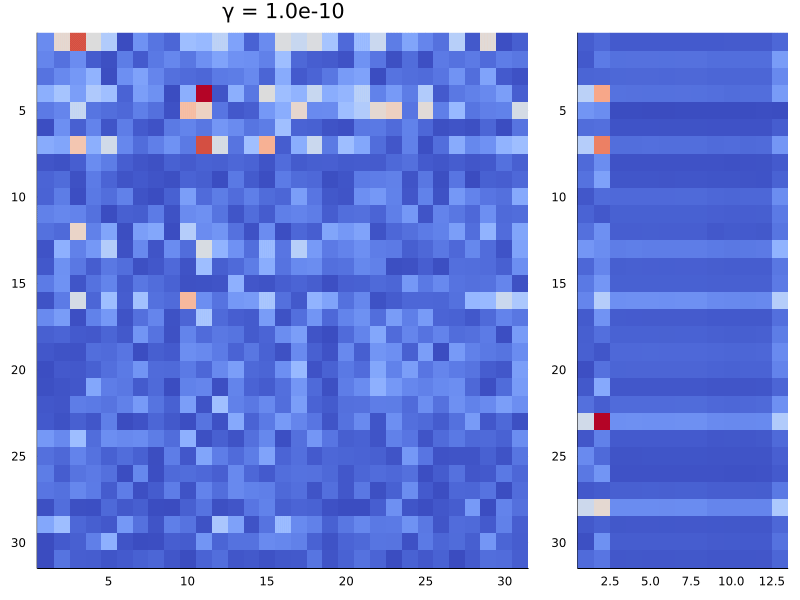

In [89]:
anim = @animate for i in 1:length(res.gammas)
    pl = plot(layout=grid(1, 2, widths=(0.7, 0.3)),  colorbar=false, size=(800, 600), yflip=true)
    heatmap!(pl[1], log1p.(abs.(res.Xs[i])), color=:coolwarm, title="γ = $(round(res.gammas[i], sigdigits=2))")
    heatmap!(pl[2], log1p.(abs.(res.Ys[i])), color=:coolwarm)
end

gif(anim, "gammaheatmap.gif", fps=1)

In [80]:
ipeds[23, :]

,UnitID,Institution Name,CINSON (DRVIC2019),COTSON (DRVIC2019),DVADM01 (DRVADM2019),DVADM04 (DRVADM2019),GBA4RTT (DRVGR2019),GBA6RTT (DRVGR2019),ACTCM25 (ADM2019),ACTCM75 (ADM2019),SATMT25 (ADM2019),SATMT75 (ADM2019),SATVR75 (ADM2019),SATVR25 (ADM2019),UGENTERN (EF2019D),CINSON (DRVIC2018),COTSON (DRVIC2018),DVADM01 (DRVADM2018_RV),DVADM04 (DRVADM2018_RV),GBA4RTT (DRVGR2018_RV),GBA6RTT (DRVGR2018_RV),ACTCM25 (ADM2018_RV),ACTCM75 (ADM2018_RV),SATMT25 (ADM2018_RV),SATMT75 (ADM2018_RV),SATVR75 (ADM2018_RV),SATVR25 (ADM2018_RV),UGENTERN (EF2018D_RV),CINSON (DRVIC2017),COTSON (DRVIC2017),DVADM01 (DRVADM2017_RV),DVADM04 (DRVADM2017_RV),GBA4RTT (DRVGR2017_RV),GBA6RTT (DRVGR2017_RV),ACTCM25 (ADM2017_RV),ACTCM75 (ADM2017_RV),SATMT25 (ADM2017_RV),SATMT75 (ADM2017_RV),SATVR75 (ADM2017_RV),SATVR25 (ADM2017_RV),UGENTERN (EF2017D_RV),CINSON (DRVIC2016),COTSON (DRVIC2016),DVADM01 (DRVADM2016_RV),DVADM04 (DRVADM2016_RV),GBA4RTT (DRVGR2016_RV),GBA6RTT (DRVGR2016_RV),ACTCM25 (ADM2016_RV),ACTCM75 (ADM2016_RV),SATMT25 (ADM2016_RV),SATMT75 (ADM2016_RV),SATVR75 (ADM2016_RV),SATVR25 (ADM2016_RV),UGENTERN (EF2016D_RV),CINSON (DRVIC2015),COTSON (DRVIC2015),DVADM01 (DRVADM2015_RV),DVADM04 (DRVADM2015_RV),GBA4RTT (DRVGR2015_RV),GBA6RTT (DRVGR2015_RV),ACTCM25 (ADM2015_RV),ACTCM75 (ADM2015_RV),SATMT25 (ADM2015_RV),SATMT75 (ADM2015_RV),SATVR75 (ADM2015_RV),SATVR25 (ADM2015_RV),UGENTERN (EF2015D_RV),CINSON (DRVIC2014),COTSON (DRVIC2014),DVADM01 (DRVADM2014_RV),DVADM04 (DRVADM2014_RV),GBA4RTT (DRVGR2014_RV),GBA6RTT (DRVGR2014_RV),ACTCM25 (ADM2014_RV),ACTCM75 (ADM2014_RV),SATMT25 (ADM2014_RV),SATMT75 (ADM2014_RV),SATVR75 (ADM2014_RV),SATVR25 (ADM2014_RV),UGENTERN (EF2014D_RV),CINSON (DRVIC2013_RV),COTSON (DRVIC2013_RV),DVIC01 (DRVIC2013_RV),DVIC04 (DRVIC2013_RV),GBA4RTT (DRVGR2013_RV),GBA6RTT (DRVGR2013_RV),ACTCM25 (IC2013_RV),ACTCM75 (IC2013_RV),SATMT25 (IC2013_RV),SATMT75 (IC2013_RV),SATVR75 (IC2013_RV),SATVR25 (IC2013_RV),UGENTERN (EF2013D_RV),CINSON (DRVIC2012_RV),COTSON (DRVIC2012_RV),DVIC01 (DRVIC2012_RV),DVIC04 (DRVIC2012_RV),GBA4RTT (DRVGR2012_RV),GBA6RTT (DRVGR2012_RV),ACTCM25 (IC2012_RV),ACTCM75 (IC2012_RV),SATMT25 (IC2012_RV),SATMT75 (IC2012_RV),SATVR75 (IC2012_RV),SATVR25 (IC2012_RV),UGENTERN (EF2012D_RV),CINSON (DRVIC2011_RV),COTSON (DRVIC2011_RV),DVIC01 (DRVIC2011_RV),DVIC04 (DRVIC2011_RV),GBA4RTT (DRVGR2011_RV),GBA6RTT (DRVGR2011_RV),ACTCM25 (IC2011_RV),ACTCM75 (IC2011_RV),SATMT25 (IC2011_RV),SATMT75 (IC2011_RV),SATVR75 (IC2011_RV),SATVR25 (IC2011_RV),UGENTERN (EF2011D_RV),CINSON (DRVIC2010_RV),COTSON (DRVIC2010_RV),DVIC01 (DRVIC2010_RV),DVIC04 (DRVIC2010_RV),GBA4RTT (DRVGR2010_RV),GBA6RTT (DRVGR2010_RV),ACTCM25 (IC2010_RV),ACTCM75 (IC2010_RV),SATMT25 (IC2010_RV),SATMT75 (IC2010_RV),SATVR75 (IC2010_RV),SATVR25 (IC2010_RV),UGENTERN (EF2010D_RV),CINSON (DRVIC2009_RV),COTSON (DRVIC2009_RV),DVIC01 (DRVIC2009_RV),DVIC04 (DRVIC2009_RV),GBA4RTT (DRVGR2009_RV),GBA6RTT (DRVGR2009_RV),ACTCM25 (IC2009_RV),ACTCM75 (IC2009_RV),SATMT25 (IC2009_RV),SATMT75 (IC2009_RV),SATVR75 (IC2009_RV),SATVR25 (IC2009_RV),UGENTERN (EF2009D_RV),CINSON (DRVIC2008_RV),COTSON (DRVIC2008_RV),DVIC01 (DRVIC2008_RV),DVIC04 (DRVIC2008_RV),GBA4RTT (DRVGR2008_RV),GBA6RTT (DRVGR2008_RV),ACTCM25 (IC2008_RV),ACTCM75 (IC2008_RV),SATMT25 (IC2008_RV),SATMT75 (IC2008_RV),SATVR75 (IC2008_RV),SATVR25 (IC2008_RV),UGENTERN (EF2008D_RV),CINSON (DRVIC2007),COTSON (DRVIC2007),DVIC01 (DRVIC2007),DVIC04 (DRVIC2007),GBA4RTT (DRVGR2007_RV),GBA6RTT (DRVGR2007_RV),ACTCM25 (IC2007),ACTCM75 (IC2007),SATMT25 (IC2007),SATMT75 (IC2007),SATVR75 (IC2007),SATVR25 (IC2007),UGENTERN (EF2007D_RV),CINSON (DRVIC2006),COTSON (DRVIC2006),DVIC01 (DRVIC2006),DVIC04 (DRVIC2006),GBA4RTT (DRVGR2006_RV),GBA6RTT (DRVGR2006_RV),ACTCM25 (IC2006),ACTCM75 (IC2006),SATMT25 (IC2006),SATMT75 (IC2006),SATVR75 (IC2006),SATVR25 (IC2006),UGENTERN (EF2006D_RV)
,Int64,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int6